In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, model_from_json
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import plot_model
from tensorflow.python.client import device_lib
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

In [2]:
for d in device_lib.list_local_devices():
    print(d.name, d.physical_device_desc)

/device:CPU:0 
/device:XLA_CPU:0 device: XLA_CPU device


# Data Injestion

In [ ]:
# x = keras.datasets.fashion_mnist.load_data()
# f = open('fashion.data', 'wb')
# pickle.dump(x, f)
# f.close()

f = open('fashion.data', 'rb')
(X_train, y_train), (X_test, y_test) = pickle.load(f)
f.close()

In [ ]:

plt.imshow(X_train[0]);

In [ ]:
X_train.shape, X_test.shape

In [ ]:
np.unique(y_train) # 10 labels

In [ ]:
# normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

# Fully Connected

In [ ]:
optimizer = Adam()
optimizer.get_config()

In [ ]:
model = Sequential([
    Flatten(input_shape=(28, 28)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.summary()

In [ ]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_split=0.3, shuffle=True, verbose=1)

In [ ]:
plt.plot(history.epoch, history.history['val_accuracy'])
plt.plot(history.epoch, history.history['accuracy'])
plt.ylim(0, 1);

# Convolutional Neural Networks

In [ ]:
# try 3x3 and 5x5
model = Sequential()
model.add(Conv2D(32, padding='same', kernel_size=(5, 5),activation='relu',input_shape=(28, 28, 1)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))
model.summary()

In [ ]:
X_train.shape

In [ ]:
X_train = X_train.reshape(-1, 28, 28, 1)
X_train.shape

In [ ]:
X_test = X_test.reshape(-1, 28, 28, 1)
X_test.shape

In [ ]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=5, validation_split=0.3, shuffle=True, verbose=1, batch_size=32)

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)

In [ ]:
score # loss, accuracy

In [ ]:
# open model.json in jupyter - it formats nicely
with open('model.json', 'w') as f:
    f.write(model.to_json())

In [ ]:
# view in VIM to verify HDF5 format
model.save_weights('weights.h5')

In [ ]:
with open('model.json', 'r') as f:
    data = f.read()
lazarus = model_from_json(data)

In [ ]:
lazarus.load_weights('weights.h5')

In [ ]:
lazarus.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lazarus.evaluate(X_test, y_test, verbose=0)[1]

# Loading Real Photos

In [3]:
# https://www.kaggle.com/c/dogs-vs-cats/data
# click "download all" button

In [4]:
# dataset generators for test and train
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
input_shape = (75, 75, 3)

In [6]:
# dataset generators for test and train
train_generator = train_datagen.flow_from_directory(
        'kaggle/train',
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='binary',
        shuffle=True)

validation_generator = test_datagen.flow_from_directory(
        'kaggle/validation',
        target_size=input_shape[:2],
        batch_size=32,
        class_mode='binary',
        shuffle=False)

Found 21000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [7]:
train_generator.batch_size

32

In [8]:
train_generator.class_indices

{'cat': 0, 'dog': 1}

In [9]:
train_generator.next()[1]

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 0.],
      dtype=float32)

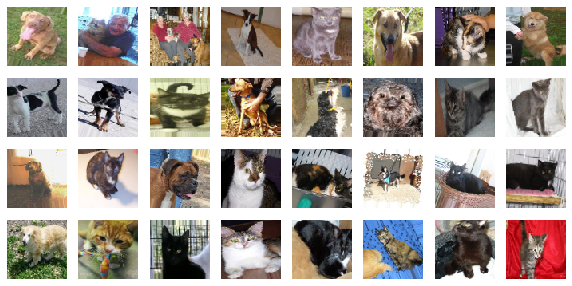

In [10]:
images = train_generator.next()[0]
fig = plt.figure(figsize=(10, 5))
for i in range(32):
    img = images[i]
    ax = fig.add_subplot(4, 8, i + 1)
    ax.imshow(img)
    ax.axis('off')

In [16]:
# baseline accuracy
validation_generator.classes.sum() / validation_generator.classes.shape[0]

0.5

In [ ]:
# mkdir -p validation/{dog,cat}
# ls | shuf -n 2000 | xargs -i mv {} ../../validation/dog/
# ls | shuf -n 2000 | xargs -i mv {} ../../validation/cat/
# ls -al | wc 

In [ ]:
model = Sequential()
model.add(Conv2D(32, padding='valid', kernel_size=(3, 3),activation='relu',input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='valid'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.summary()

In [ ]:
# number of batches in epoch
# added 2x for training to get more random samples
train_batches_per_epoch = int(train_generator.samples / train_generator.batch_size) * 2
validation_batches_per_epoch = int(validation_generator.samples / validation_generator.batch_size)
train_batches_per_epoch, validation_batches_per_epoch

In [ ]:
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit_generator(train_generator, steps_per_epoch=train_batches_per_epoch, 
                              epochs=2, validation_data=validation_generator, 
                              validation_steps=validation_batches_per_epoch, verbose=1)

In [ ]:
# plot history